# Práctica 1: Búsquedas en espacios de estados

<center><h3>
   Pedro López-Chaves Pérez
</h3></center>

## Instrucciones

Esto es **Jupyter Notebook**, un documento que integra código Python en un archivo Markdown.
Esto nos permite ir ejecutando celdas de código poco a poco, así como generar automáticamente un informe bien formateado de la práctica.

Puedes añadir una celda con el botón **"Insert"** de la barra de herramentas, y cambiar su tipo con **"Cell > Cell Type"**

Para ejecutar una celda de código, la seleccionaremos y pulsaremos el botón **"▶ Run"** de la barra de herramentas.
Para pasar el documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Sigue este guión hasta el final. Ejecuta el código proporcionado paso a paso comprendiendo lo que estás haciendo y reflexionando sobre los resultados. Habrá preguntas intercaladas a lo largo del guión, responde a todas ellas en la sección reservada para ese fin: **"Respuestas a los cuestionarios"**. Por favor, no modifiques ninguna linea de código excepto cuando se te pida explícitamente.

No olvides insertar tu **nombre y apellidos** en la celda superior.

## Entrega de la práctica

La fecha límite de entrega será la indicada en el Campus Virtual. La entrega consistirá de un único archivo comprimido con nombre `APELIDOS_NOME_Busquedas.zip` que contenga los seguientes ficheros:

 * `APELIDOS_NOME_Busqueda.html`: Archivo HTML fruto de la exportación del presente Notebook, con las preguntas respondidas al final del documento.
 * `APELIDOS_NOME_Busqueda.ipynb`: Archivo fuente Jupyter Notebook.
 * Archivo de datos del problema de libre elección.

## Introducción a AIMA-Python


El libro de consulta de referencia para esta práctica es el "Artificial Intelligence: A Modern Approach." (conocido como AIMA http://aima.cs.berkeley.edu/) de Russell y Norvig. En particular, el capítulo 3 ofrece una panorámica completa sobre técnicas clásicas de resolución de problemas basadas en búsqueda en espacios de estados. 

El libro viene con un conjunto de módulos Python que contiene muchos de los algoritmos implementados. Es por ello, que en la medida de lo posible utilizaremos sus implementaciones, que originalmente pueden consultarse en el repositorio de AIMA-Python https://github.com/aimacode/aima-python, y de los que hemos incorporado una copia adaptada a las necesidades de nuestra Asignatura en este boletín.

Para trabajar con los algoritmos de búsqueda relevantes, primero nos familiarizaremos con las clases y funciones clave que nos permitirá resolver problemas mediante estrategias de búsqueda vistas en las sesiones expositivas. Será entonces que trabajaremos con un problema conocido, el 8-puzzle, realizando pequeñas modificaciones al código existente para incorporar y estudiar el comportamiento de las heurísticas. Finalmente, se os pedirá que implementéis completamente una solución al problema del Viajante de Comercio y estudieis las heurísticas que implementeis. 

¡Empecemos!

En primer lugar, empecemos por importar los módulos python especialmente preparados para esta Práctica 1.

In [1]:
# contiene algoritmos de búsqueda implementado en AIMA
from search_mod import *

# algunas funciones auxiliares
from helpers_mod import *

Podemos consultar el código de algunas clases y funciones clave mediante el uso de `psource(symbol)`. Por ejemplo, `psource(Problem)` mostrará el código de la clase Problem. 

Esta clase es fundamental pues, como mostraremos más abajo, se trata de una clase abstracta que puede extenderse para implementar la resolución de problemas concretos en base a los siguientes métodos:
- actions(state): devuelve una lista de operadores o acciones que son aplicables al estado actual
- result(state, action): devuelve el nuevo estado resultante de aplicar la acción action al estado state
- is_goal(state): devuelve cierto sii se ha alcanzando un estado meta o objetivo
- action_cost(s, action, s1): calcula el coste de aplicar la action para pasar del estado s al s1
- h(node): función heurística que se emplea en estrategias informadas

Cabe destacar que las estrategias de búsqueda se basan en búsquedas sobre grafos/árboles, y por lo tanto los algoritmos manejan nodos, que mantienen la relación entre los mismos, el coste del camino, y el estado que el nodo debe representar. De ahí, la clase `Node` tiene los atributos `state, parent, action, path_cost`.

Empieza por inspeccionar el código de las clases/funciones: `breadth_first_search, best_first_search, astar_search, expand, g, Problem, Node`.

In [15]:
psource(Problem)
psource(Node)
psource(breadth_first_search)
psource(best_first_search)
psource(astar_search)
psource(expand)
psource(g)

In [26]:
psource(problem.h)

❓ **Pregunta 1**.

- 1.1) Fíjate en la implementación de `breadth_first_search` y `astar_search`. Podemos observar algunas similitudes (p.ej., existe un bucle que explora un conjunto de nodos que llama frontera (nodos pendientes), expande el nodo para producir los sucesores (nodos-hijo)). Ahora indica las diferencias y explica cómo crees que esas diferencias determinan el comportamiento de sendas estrategias de búsqueda. **Pista**: Fíjate en la estructura de datos para los nodos frontera. 

- 1.2) En la implementación disponible de la estrategia A*, ¿qué calcula la función g(n)?



## El problema del 8-Puzzle



![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

El problema del 8-puzzle se plantea como un tablero 3x3 que contiene ocho fichas numeradas que se
pueden mover gracias a que una de las posiciones contiene un espacio en blanco o hueco. El objetivo
del juego es alcanzar el estado meta o objetivo indicado partiendo de un estado inicial dado, limitándose a
realizar movimientos permitidos del blanco. Una solución, entendida como un proceso de resolución, viene dada
por la secuencia de acciones o pasos que permiten alcanzar el estado meta.

Este problema forma parte de la familia de puzzles o rompecabezas de piezas deslizantes, que
pertenecen a la categoría de problemas NP. Tallas del problema más grandes, esto es, tableros con
mayor número de fichas puede hacer su resolución impracticable. Aun así, el 8-puzzle es útil para
probar algoritmos que implementen estrategias de búsqueda como los que utilizarás en esta práctica
pues se puede resolver en unos milisegundos a pesar de los 9!/2=181440 estados alcanzables.

Como ya adelantábamos, la clase `Problem` puede extenderse para resolver problemas particulares.

La siguiente implementación permite usar los algoritmos de búsqueda que vienen implementados en AIMA-Python para resolver el problema del 8-puzzle.

In [16]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)
    
    def h2(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)    
    
    def h(self, node): return self.h2(node)
    
    
def hamming_distance(A, B):
    "Number of positions where vectors A and B are different."
    return sum(a != b for a, b in zip(A, B))
    

def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')



In [17]:
class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height) 
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty
        
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

Puedes crear instancias de problemas del 8-Puzzle de la siguiente forma:

In [18]:
# Ejemplos de creación de instancias del problema del 8-puzzle
e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [28]:
exam= EightPuzzle( (1, 3, 5, 8, 7, 2, 4, 6, 0) )

In [31]:
sol=astar_manhatan(exam)
print ("Nodo solución: ", sol)


# e imprimir informacion relevante utilizando los atributos y funciones siguientes
print (f'Coste del camino: {sol.path_cost:d}')
print (f'Estado solución: {sol.state:}')
print (f'Estado solución (tablero):')
print (board8(sol.state))
print (f'Lista de acciones: {path_actions(sol)}')
print (f'Numero de acciones en el camino: {len(path_actions(sol))}')
print (f'Lista de estados:')
print (path_states(sol))

# lista de estados formateado
for s in path_states(sol):
    print(board8(s))

Nodo solución:  <(0, 1, 2, 3, 4, 5, 6, 7, 8)>
Coste del camino: 24
Estado solución: (0, 1, 2, 3, 4, 5, 6, 7, 8)
Estado solución (tablero):
_ 1 2
3 4 5
6 7 8

Lista de acciones: [5, 4, 3, 6, 7, 8, 5, 4, 7, 6, 3, 0, 1, 4, 3, 6, 7, 8, 5, 2, 1, 4, 3, 0]
Numero de acciones en el camino: 24
Lista de estados:
[(1, 3, 5, 8, 7, 2, 4, 6, 0), (1, 3, 5, 8, 7, 0, 4, 6, 2), (1, 3, 5, 8, 0, 7, 4, 6, 2), (1, 3, 5, 0, 8, 7, 4, 6, 2), (1, 3, 5, 4, 8, 7, 0, 6, 2), (1, 3, 5, 4, 8, 7, 6, 0, 2), (1, 3, 5, 4, 8, 7, 6, 2, 0), (1, 3, 5, 4, 8, 0, 6, 2, 7), (1, 3, 5, 4, 0, 8, 6, 2, 7), (1, 3, 5, 4, 2, 8, 6, 0, 7), (1, 3, 5, 4, 2, 8, 0, 6, 7), (1, 3, 5, 0, 2, 8, 4, 6, 7), (0, 3, 5, 1, 2, 8, 4, 6, 7), (3, 0, 5, 1, 2, 8, 4, 6, 7), (3, 2, 5, 1, 0, 8, 4, 6, 7), (3, 2, 5, 0, 1, 8, 4, 6, 7), (3, 2, 5, 4, 1, 8, 0, 6, 7), (3, 2, 5, 4, 1, 8, 6, 0, 7), (3, 2, 5, 4, 1, 8, 6, 7, 0), (3, 2, 5, 4, 1, 0, 6, 7, 8), (3, 2, 0, 4, 1, 5, 6, 7, 8), (3, 0, 2, 4, 1, 5, 6, 7, 8), (3, 1, 2, 4, 0, 5, 6, 7, 8), (3, 1, 2, 0, 4, 5, 6, 7, 8),

y puedes proceder a resolver el problema mediante la estrategia de búsqueda A* de la siguiente manera, que retorna el Node correspondiente al estado solución

In [6]:
# resolver una instancia particular con una estrategia de búsqueda concreta
# retorna la solución, como una instancia de Node
print(f'Resolver el problema {e1} con A*')
sol = astar_search(e1)
print ("Nodo solución: ", sol)

Resolver el problema EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8), (0, 1, 2, 3, 4, 5, 6, 7, 8)) con A*
Nodo solución:  <(0, 1, 2, 3, 4, 5, 6, 7, 8)>


Para este problema, como el nodo de la solución es sencillamente el nodo meta, y éste era una entrada al problema, no resulta muy informativo. Sin embargo, sí podemos consultar los atributos de dicho nodo e incluso obtener los movimientos que condujeron al estado objetivo desde el estado inicial. 

Veamos cómo puedes obtener esta información.

In [7]:
# e imprimir informacion relevante utilizando los atributos y funciones siguientes
print (f'Coste del camino: {sol.path_cost:d}')
print (f'Estado solución: {sol.state:}')
print (f'Estado solución (tablero):')
print (board8(sol.state))
print (f'Lista de acciones: {path_actions(sol)}')
print (f'Numero de acciones en el camino: {len(path_actions(sol))}')
print (f'Lista de estados:')
print (path_states(sol))

# lista de estados formateado
for s in path_states(sol):
    print(board8(s))

Coste del camino: 5
Estado solución: (0, 1, 2, 3, 4, 5, 6, 7, 8)
Estado solución (tablero):
_ 1 2
3 4 5
6 7 8

Lista de acciones: [6, 7, 4, 1, 0]
Numero de acciones en el camino: 5
Lista de estados:
[(1, 4, 2, 0, 7, 5, 3, 6, 8), (1, 4, 2, 3, 7, 5, 0, 6, 8), (1, 4, 2, 3, 7, 5, 6, 0, 8), (1, 4, 2, 3, 0, 5, 6, 7, 8), (1, 0, 2, 3, 4, 5, 6, 7, 8), (0, 1, 2, 3, 4, 5, 6, 7, 8)]
1 4 2
_ 7 5
3 6 8

1 4 2
3 7 5
_ 6 8

1 4 2
3 7 5
6 _ 8

1 4 2
3 _ 5
6 7 8

1 _ 2
3 4 5
6 7 8

_ 1 2
3 4 5
6 7 8



Además de ver la traza, puedes también inspeccionar el código de `path_actions` y `path_states` para ver su implementación con el objetivo de entender cómo funciona internamente.

In [8]:
psource(path_actions)
psource(path_states)

❓ **Pregunta 2**. La clase EightPuzzle implementa el problema para el Puzzle, especificando la codificación del estado, los operadores y el modelo de transición entre estados. Atendiendo a la implementación disponible, responde de manera razonada a las siguientes cuestiones:

- 2.1) Describe qué estructura de datos se utiliza y cómo se representado el estado en la implementación dada.
- 2.2) ¿Qué operadores (u acciones) puede aplicar el agente inteligente? y ¿Cómo se implementa el modelo de transición (i.e.,  cómo se determinan  los operadores  aplicables  y se lleva a cabo la acción adecuada)? Explícalo brevemente. 
- 2.3) ¿Dónde almacena el coste de la solución obtenida? ¿y dónde se almacena los operadores o acciones seguidas para alcanzar el estado meta?
- 2.4) Prueba a resolver el problema con otra instancia del problema del 8-puzzle no definida anteriormente. ¿Qué instancia has probado? ¿Cuál es el coste del camino de dicha resolución? Incluye el código de tus pruebas en la celda.


In [9]:
# Celda asociada a la Pregunta 2.4
#2.4
nueva=EightPuzzle((6,2,7,4,5,1,3,8,0))
print(f'Resolver el problema {nueva} con A*')
sol = breadth_first_search(nueva)
print ("Nodo solución: ", sol)
# e imprimir informacion relevante utilizando los atributos y funciones siguientes
print (f'Coste del camino: {sol.path_cost:d}')
print (f'Estado solución: {sol.state:}')
print (f'Estado solución (tablero):')
print (board8(sol.state))
print (f'Lista de acciones: {path_actions(sol)}')
print (f'Numero de acciones en el camino: {len(path_actions(sol))}')
print (f'Lista de estados:')
print (path_states(sol))

# lista de estados formateado
for s in path_states(sol):
    print(board8(s))


Resolver el problema EightPuzzle((6, 2, 7, 4, 5, 1, 3, 8, 0), (0, 1, 2, 3, 4, 5, 6, 7, 8)) con A*
Nodo solución:  <(0, 1, 2, 3, 4, 5, 6, 7, 8)>
Coste del camino: 26
Estado solución: (0, 1, 2, 3, 4, 5, 6, 7, 8)
Estado solución (tablero):
_ 1 2
3 4 5
6 7 8

Lista de acciones: [7, 6, 3, 0, 1, 4, 3, 6, 7, 4, 5, 2, 1, 0, 3, 4, 5, 2, 1, 0, 3, 6, 7, 4, 1, 0]
Numero de acciones en el camino: 26
Lista de estados:
[(6, 2, 7, 4, 5, 1, 3, 8, 0), (6, 2, 7, 4, 5, 1, 3, 0, 8), (6, 2, 7, 4, 5, 1, 0, 3, 8), (6, 2, 7, 0, 5, 1, 4, 3, 8), (0, 2, 7, 6, 5, 1, 4, 3, 8), (2, 0, 7, 6, 5, 1, 4, 3, 8), (2, 5, 7, 6, 0, 1, 4, 3, 8), (2, 5, 7, 0, 6, 1, 4, 3, 8), (2, 5, 7, 4, 6, 1, 0, 3, 8), (2, 5, 7, 4, 6, 1, 3, 0, 8), (2, 5, 7, 4, 0, 1, 3, 6, 8), (2, 5, 7, 4, 1, 0, 3, 6, 8), (2, 5, 0, 4, 1, 7, 3, 6, 8), (2, 0, 5, 4, 1, 7, 3, 6, 8), (0, 2, 5, 4, 1, 7, 3, 6, 8), (4, 2, 5, 0, 1, 7, 3, 6, 8), (4, 2, 5, 1, 0, 7, 3, 6, 8), (4, 2, 5, 1, 7, 0, 3, 6, 8), (4, 2, 0, 1, 7, 5, 3, 6, 8), (4, 0, 2, 1, 7, 5, 3, 6, 8), (0, 4, 2, 1

## Laboratorio de algoritmos de búsqueda: 8-Puzzle

Lo interesante de disponer de la implementación de varios algoritmos en una librería/módulo es que podemos disponer de ellos sin demasiado esfuerzo y podemos comparar y estudiar su desempeño.

En las clases de teoría habéis visto algunos algoritmos para la búsqueda en espacios de estados que realizan una búsqueda a ciegas, entre los que destacan la búsqueda en anchura o amplitud. Cuando se lleva a cabo una búsqueda a ciegas, también se dice que se realiza una búsqueda *no-informada*.

Además, habéis también visto algoritmos de búsqueda heurística, que en contraposición a los algoritmos de búsqueda ciega, incorpora una función heurística y de evaluación que permite realizar una búsqueda más guiada (por tanto, menos ciega) teniendo en cuenta información potencialmente útil. A la búsqueda heurística se le conoce también como búsqueda informada, por incorporar esa información de guiado adicional en su función. 

Algunas de las estrategias de búsqueda, tanto ciegas como heurísticas, que podemos hacer uso directamente son las siguientes:

|Algoritmo|Función python|*f*|
|:---------|--|---:|
|Breadth search |`breadth_first_search`| no-informada |
|Depth search | `depth_limited_search`|no-informada|
|Greedy best-first search |` greedy_bfs `| *f = h*|
|Uniform-cost search |` uniform_cost_search `| *f = g*|
|A* search |` astar_search `| *f = g + h*|
|Weighted A* search | ` weighted_astar_search ` | *f = g + 1.4 &times; h*|


Utilizando las funciones vistas hasta el momento y las sugeridas en la tabla, prueba a ejecutar algunas de las estrategias disponibles y verifica el resultado con varias de las instancias definidas arriba.

In [10]:
# prueba a ejecutar algunas de las estrategias disponibles y verifica el resultado. Prueba con varias de las instancias.

print(f'Resolver el problema {e3} con A*')
sol = breadth_first_search(e3)
print ("Nodo solución: ", sol)
print (f'Coste del camino: {sol.path_cost:d}')

print(f'Resolver el problema {e3} con A*')
sol = astar_search(e3)
print ("Nodo solución: ", sol)
print (f'Coste del camino: {sol.path_cost:d}')


Resolver el problema EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6), (0, 1, 2, 3, 4, 5, 6, 7, 8)) con A*
Nodo solución:  <(0, 1, 2, 3, 4, 5, 6, 7, 8)>
Coste del camino: 23
Resolver el problema EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6), (0, 1, 2, 3, 4, 5, 6, 7, 8)) con A*
Nodo solución:  <(0, 1, 2, 3, 4, 5, 6, 7, 8)>
Coste del camino: 23


### Comparacion de múltiples estrategias de búsqueda

Ahora que eres capaz de ejecutar diferentes estrategias de búsqueda, podemos proceder a compararlas.

Para facilitar esta labor, disponemos de la función `report`, que nos permite obtener el resumen de estadísticas para un algoritmo o estrategia de búsqueda. Para colectar las estadísticas, esta función hace uso de la clase `CountCalls`, que envuelve un objeto `Problem` de tal forma que las llamadas a sus métodos se delegan al problema original a la vez que incrementa un contador.

Echa un vistazo al código de esta función y clase.

In [39]:
psource (report)
psource (CountCalls)
psource (report_counts)

Para obtener las estadísticas resultantes de la aplicación de múltiples estrategias a la resolución de un conjunto de instancias del problema, tan solo necesitamos establecer los parámetros de la función `report`.

Veamos un ejemplo en el que le indicamos que queremos resolver las instancias e1-e5 utilizando búsqueda en anchura, en profundidad (limitada), búsqueda voraz primero el mejor, búsqueda de coste uniforme y la búsqueda A*.

In [41]:
p1= EightPuzzle((4, 8, 5, 1, 3, 0, 6, 2, 7))
p2= EightPuzzle((1, 4, 8, 6, 7, 2, 5, 0, 3))
p3= EightPuzzle((2, 0, 7, 5, 3, 1, 4, 6, 8))
p4= EightPuzzle((1, 4, 2, 0, 6, 8, 7, 5, 3))
p5= EightPuzzle((1, 0, 4, 2, 3, 8, 6, 5, 7))
p6= EightPuzzle((5, 6, 7, 0, 8, 1, 3, 4, 2))

# Y esto es la función que utilizando gaschnig nos permita resolver desde la función report
def astar_gaschnig(problem): return astar_search(problem, h=problem.h_gaschnig_distance)

def astar_manhatan(problem): return astar_search(problem, h=problem.h2)

def astar_desordenadas(problem): return astar_search(problem, h=problem.h1)


In [42]:
report( (breadth_first_search,astar_gaschnig,astar_manhatan,astar_desordenadas) , (p1,p2,p3,p4,p5,p6))

breadth_first_search:
   54,004 nodes |   54,005 goal |   19 cost | EightPuzzle((4, 8, 5, 1, 3, 0, 6, 2, 7),
  136,922 nodes |  136,923 goal |   21 cost | EightPuzzle((1, 4, 8, 6, 7, 2, 5, 0, 3),
   53,599 nodes |   53,600 goal |   19 cost | EightPuzzle((2, 0, 7, 5, 3, 1, 4, 6, 8),
    1,942 nodes |    1,943 goal |   11 cost | EightPuzzle((1, 4, 2, 0, 6, 8, 7, 5, 3),
   62,878 nodes |   62,879 goal |   19 cost | EightPuzzle((1, 0, 4, 2, 3, 8, 6, 5, 7),
  150,110 nodes |  150,111 goal |   21 cost | EightPuzzle((5, 6, 7, 0, 8, 1, 3, 4, 2),
  459,455 nodes |  459,461 goal |  110 cost | TOTAL

astar_gaschnig:
    5,687 nodes |    2,092 goal |   19 cost | EightPuzzle((4, 8, 5, 1, 3, 0, 6, 2, 7),
   13,473 nodes |    4,922 goal |   21 cost | EightPuzzle((1, 4, 8, 6, 7, 2, 5, 0, 3),
    5,605 nodes |    2,029 goal |   19 cost | EightPuzzle((2, 0, 7, 5, 3, 1, 4, 6, 8),
      157 nodes |       57 goal |   11 cost | EightPuzzle((1, 4, 2, 0, 6, 8, 7, 5, 3),
    6,291 nodes |    2,296 goal |   19 

In [11]:
report((breadth_first_search, depth_limited_search, greedy_bfs, uniform_cost_search, astar_search, weighted_astar_search), 
       (e1, e2, e3, e4, e5))

breadth_first_search:
       81 nodes |       82 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
  160,948 nodes |  160,949 goal |   22 cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
  218,263 nodes |  218,264 goal |   23 cost | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  418,771 nodes |  418,772 goal |   26 cost | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  448,667 nodes |  448,668 goal |   27 cost | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
1,246,730 nodes |1,246,735 goal |  103 cost | TOTAL

depth_limited_search:
      351 nodes |      349 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    1,340 nodes |    1,341 goal |  inf cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    1,544 nodes |    1,545 goal |  inf cost | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
    1,832 nodes |    1,833 goal |  inf cost | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
    1,544 nodes |    1,545 goal |  inf cost | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
    6,611 nodes |    6,613 goal |

❓ **Pregunta 3**. Ejecuta la comparación de estrategias de búsqueda y responde a las siguientes cuestiones de manera justificada en relación a las medidas obtenidas.

- 3.1) Explica brevemente qué significan los indicadores *nodes, goal y cost* que muestra la salida de `report`.
- 3.2) ¿Qué desventajas o limitaciones consideras que tienen las búsquedas no-informadas? ¿Por qué? **Pista**: Revisa lo que viste en la expositiva al respecto de la complejidad computacional.
- 3.3) ¿Qué estrategias obtienen soluciones óptimas? ¿Si cambiaramos las instancias del problema, esas estrategias seguirían obteniendo soluciones óptimas siempre?
- 3.4) Discute de manera justificada el rendimiento de los algoritmos en términos del coste del camino/solución (optimalidad) y el número de nodos explorados.
- 3.5) ¿Qué (función) heurística ha utilizado `astar_search`?

**Pistas**: En la expositiva has visto lo que es una búsqueda óptima, que es aquella que encuentra la mejor solución, si existe, independientemente de si el proceso de búsqueda es eficiente o no. Por lo tanto, aquí nos referimos a la solución óptima como aquella mejor solución posible. 


## Implementación de heurísticas en A*: 8-puzzle



Las estrategias de búsquedas informadas (heurísticas) utilizan conocimiento específico del problema
y vienen dirigidas por una función de evaluación que gobierna la expansión de los nodos de la forma
f(n) = g(n) + h(n), donde 

- g(n) = el coste real de haber alcanzado el nodo/estado n

- h(n) = el coste estimado del camino más "barato" desde el estado n hasta un estado objetivo (Nota: el más "barato" se suele referir al más corto o al de menor coste, pero depende del problema específico)

y que, por tanto, da cuenta del coste del camino construido hasta el estado actual y el coste estimado
heurísticamente de lo que queda hasta alcanzar un estado objetivo. La función heurística h(n) es la
responsable de codificar el conocimiento específico para realizar la búsqueda de manera informada,
y es considerada una función arbitraria, no-negativa, que cumple además la restricción de h(n)=0 si n
es un estado objetivo.

De esta forma, existen algunas estrategias de búsqueda bien conocidas caracterizadas por la
estructura de la función de evaluación, que ya has empleado anteriormente.
- Búsqueda voraz primero el mejor (Greedy best-first search): intenta expandir el nodo que está más cerca del objetivo, con el fundamento de que esto lleve probablemente a una solución más rápidamente a expensas de la optimalidad de la solución. La evaluación se lleva a cabo sólo con la función heurística: f(n) = h(n)
- Búsqueda A*: De manera amplia se combina tanto el coste del camino recorrido como la estimación de lo que queda, con el objetivo de minimizar el coste total estimado mientras considera reducir el coste de la solución intermedia construida: f(n) = g(n) + h(n)

Puedes comprobar la función f de cada una de estas estrategias, como sigue.

In [42]:
psource (greedy_bfs)
psource (astar_search)
psource (best_first_search)
psource(Problem)

Típicamente, se pueden diseñar funciones heurísticas h transformando el problema original en un
problema relajado o problema con restricciones relajadas. Por ejemplo, el problema original del 8-
puzzle se define como sigue: *Una ficha puede moverse de la posición A a la B si A es adyacente (ya sea
horizontal o verticalmente) a B, y B es el blanco*. Partiendo de esa formulación, podemos generar tres
problemas relajados mediante la eliminación de una o ambas condiciones:
- (a) Una ficha puede moverse de la posición A a la B is A es adyacente a B.
- (b) Una ficha puede moverse de la posición A a la B si B es blanco.
- (c) Una ficha puede mover de la posición A a la B.

En los ejemplos de la implementación del 8-puzzle, las funciones de evaluación emplean como función heurística
h las siguientes, que se corresponden con la formulación de los problemas relajados (c) y (a)
respectivamente:
- h1 (n) = número de fichas que en el estado n están descolocadas o fuera de su posición en el objetivo = distancia de Hamming
- h2 (n) = suma de las distancias ortogonales de cada ficha a su posición en el estado objetivo = distancia de Manhattan


Cabe destacar que, por defecto, la implementación `EightPuzzle` utiliza la distancia de Manhattan (i.e., h2). Por tanto, para hacer uso de la h1 y poder incluir el uso de dicha estrategia en la comparativa necesitamos definir previamente una función `astar_misplaced_tiles` como se ejemplifica a continuación.

In [48]:
def astar_misplaced_tiles(problem): return astar_search(problem, h=problem.h1)
psource(astar_search)
psource(Problem)

Que podemos entonces utilizar como cualquier otra función que implementa una estrategia de búsqueda.

In [14]:
sol2=astar_misplaced_tiles(e1)
for s in path_states(sol2):
    print(board8(s))

report([astar_misplaced_tiles, astar_search], [e1, e2])

1 4 2
_ 7 5
3 6 8

1 4 2
3 7 5
_ 6 8

1 4 2
3 7 5
6 _ 8

1 4 2
3 _ 5
6 7 8

1 _ 2
3 4 5
6 7 8

_ 1 2
3 4 5
6 7 8

astar_misplaced_tiles:
       17 nodes |        7 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   23,407 nodes |    8,726 goal |   22 cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   23,424 nodes |    8,733 goal |   27 cost | TOTAL

astar_search:
       15 nodes |        6 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    3,614 nodes |    1,349 goal |   22 cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    3,629 nodes |    1,355 goal |   27 cost | TOTAL




Finalmente, la función heurística correspondiente al problema relajado (b), conocida como heurística de Gaschnig,
se define como
- h3 (n) = número de intercambios con el blanco para transformar el estado inicial en el objetivo

Ésta puede implementarse siguiendo el siguiente pseudocódigo:

`
    nmovimientos = 0
    e=estado actual n
    MIENTRAS e no es objetivo HACER
        SI e.posicion_blanco está en la posición objetivo ENTONCES
            e=e.intercambiar_blanco_con_cualquier_descolocada
        SINO
            e=e.intercambiar_blanco_con_ficha_que_corresponde_a_esa_posicion
        FSI
        nmovimientos = nmovimientos + 1
    FMIENTRAS
`

A modo ilustrativo del intercambio del blanco con la ficha que correspondería a esa posición, supón
que tienes el estado representado en la figura a la izquierda. El resultado de los dos primeros
intercambios sería como se ilustra en los tableros de la derecha.
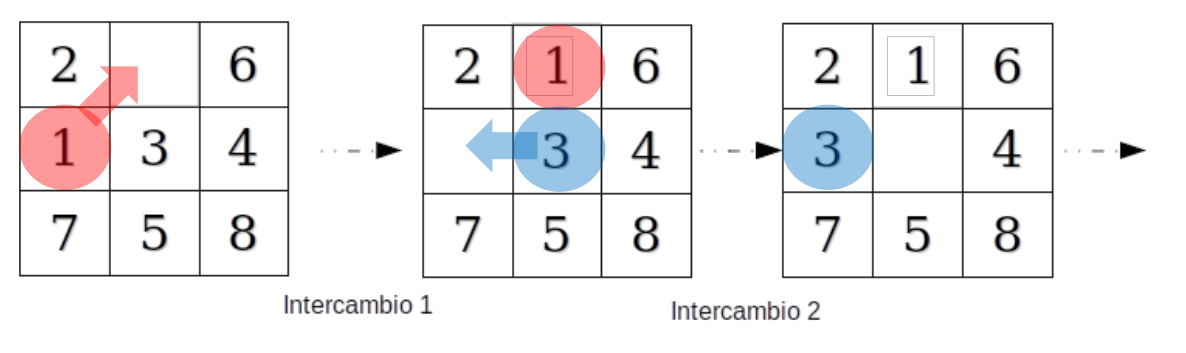



Incluimos a continuación una implementación de la distancia de Gaschnig y su intergración en EightPuzzle.

**Importante**: Tras ejecutar la siguiente celda, cualquier instancia de EightPuzzle definida previamente debería reinstanciarse para que sea acorde a la nueva implementación de EightPuzzle.

In [30]:
# Redefinimos la clase EightPuzzle, pero esta vez hemos añadido la implementación de la heurística. 
# Importante: Cualquier instancia de EightPuzzle previa debería reinstanciarse para que sea acorde a la nueva implementación
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)
    
    def h2(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)    
    
    def h(self, node): return self.h2(node)
    
     # Esta es una posible implementaciónde la distancia de Gaschnig
    def h_gaschnig_distance(self, node):        
        node_state = list(node.state)
        goal = list(self.goal)
        distance = 0
        while node_state != goal:            
            if (node_state.index(0) == goal.index (0)):                
                idxGap = node_state.index(0)
                swapIdx = 0                
                misplacedFound = False
                while (swapIdx < 9 and not misplacedFound):
                    if node_state[swapIdx] != goal[swapIdx] and node_state[swapIdx] != 0:
                        misplacedFound = True                        
                    else:
                        swapIdx = swapIdx + 1

                swapValue = node_state[swapIdx]
                node_state [idxGap] = swapValue
                node_state [swapIdx] = 0
                
            else:                            
                idxGap = node_state.index(0)
                
                swapValue = goal[idxGap]                
                swapIdx = node_state.index(swapValue)

                node_state[idxGap] = swapValue
                node_state[swapIdx] = 0                         
                
                
            distance = distance + 1

        return distance
    
# Y esto es la función que utilizando gaschnig nos permita resolver desde la función report
def astar_gaschnig(problem): return astar_search(problem, h=problem.h_gaschnig_distance)

def astar_manhatan(problem): return astar_search(problem, h=problem.h2)




❓ **Pregunta 4**. Compara las tres heurísticas del 8-Puzzle y discútelas de manera justificada. Incluye la búsqueda en anchura en la comparativa. ¿Qué función heurística es más informada? ¿Cómo ha funcionado en promedio esta tercera heurística en relación con las otras dos? ¿En qué proporción o orden de magnitud funciona la búsqueda con heurística que sin ella?

No olvides incluir el código que has tenido que desarrollar para realizar la tabla comparativa resultante. 

**Pista**: Cuando disponemos de varias funciones heurísticas que utilizan la estrategia A\*, decimos que una función es más informada que otra cuando la primera necesita expandir menos nodos que la segunda. Asumimos entonces que debido a la mayor información condificada en la función heurística, o al menos aprovechada de mejor forma, permite guiar mejor el proceso de búsqueda de tal forma que la estimación dada por la función *h* se ajusta/acerca más a la realidad del coste pendiente.


In [3]:
def astar_h_gaschnig_distance(problem): return astar_search(problem, h=problem.h_gaschnig_distance)
psource(astar_search)
psource(best_first_search)

NameError: name 'psource' is not defined

In [18]:
# Celda asociada a Pregunta 4
# Pon aquí el código para realizar la comparación 

#H1 astar_misplaced_tiles
#H2 astar_search

report((breadth_first_search,astar_misplaced_tiles, astar_search,astar_gaschnig ), (e1, e2, e3, e4, e5))


breadth_first_search:
       81 nodes |       82 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
  160,948 nodes |  160,949 goal |   22 cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
  218,263 nodes |  218,264 goal |   23 cost | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  418,771 nodes |  418,772 goal |   26 cost | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  448,667 nodes |  448,668 goal |   27 cost | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
1,246,730 nodes |1,246,735 goal |  103 cost | TOTAL

astar_misplaced_tiles:
       17 nodes |        7 goal |    5 cost | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   23,407 nodes |    8,726 goal |   22 cost | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   38,632 nodes |   14,433 goal |   23 cost | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  124,324 nodes |   46,553 goal |   26 cost | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  156,111 nodes |   58,475 goal |   27 cost | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
  342,491 nodes |  128,194 goal 

Comenzamos por destacar una gran diferencia de eficiencia en las busquedas guíadas que en la de anchura, ya que aunque todas llegan a la solución óptima en todos los casos; las estrategías guiadas necesitan visitar un numero ridículo de nodos frente a anchura.Calculamos a continuación la proporcion:

    1. hacemos una media aproximada de los nodos visitados por las busquedas guiadas: (342k+31k+295k)/3=222k
    2. divivimos nodos visitados por la no guiada y la media de las guiadas: 1.246k / 222k = 5,6

Podemos afirmar que las busquedas guiadas son mas de 5 veces y media superiores a las no guiadas.

Ya entrando en la comparación entre las 3 guíadas podemos afirmar, por el numero de nodos visitados, que la más eficiente es h2, seguida de Gasching y esta seguida de h1. Esto se debe a que h2 calcula las distancias por manhatan, es decir, calcula la distancia al sumar todas las distancias de los estados de los nodos al estado final con lo que se logra una gran estimación.

Gasching, en cambio, basa su función heurística en ir nodo uno por uno contando cuantos desplazamientos del elemento vacío hacen falta para llegar a su posición deseada. Con respecto a h2, que la mejora, la diferencia es que Gasching solo se va fijando nodo a nodo mientras que h2 ve el problema de manera más global lo que le permite obtener una mejor solución.

H1 calcula la distancia según hamming, que lo que hace es contar todos los nodos que se encuentran fuera de su posicion final para calcular la distancia. A diferencia de Manhatan y Gasching, hamming no tiene en cuenta de a cuanta distancia se encuentran de la posición final, solo si estan en ella o no; es por esto que se pierde calidad en el guiado y se visitan mas nodos para llegar a la misma posción 


## El problema de Viajante de Comercio (VC)

El objetivo de este bloque es modelar e implementar un agente inteligente que sea capaz de resolver
el problema del VC mediante estrategias de búsqueda A*, haciendo uso de AIMA como te has familiarizado anteriormente.


### Definición del problema

El problema del viajante de comercio (VC) es el problema de la persona que quiere vender un producto, y que para ello quiere encontrar el viaje más corto posible a través de las ciudades de los clientes, haciendo una única visita a cada una, empezando y acabando el recorrido en su propia ciudad (recorrido circular desde la ciudad inicial).

Típicamente, el problema parte de una representación mediante un grafo ponderado G=(N, A), donde N es el conjunto de n=|N| nodos (ciudades), y siendo A el conjunto de arcos conectando los nodos. Cada arco (i, j) ∈ A tiene asignado un peso d_ij que representa la distancia entre las ciudades i y j.

Para facilitar vuestra labor de implementación, os proporcionamos la clase `Localizaciones`, que permite cargar las localizaciones GPS que representan los vértices del grafo G de N ciudades, y permite calcular de manera transparente la distancia entre cualquier par de ciudades usando la fórmula del semiverseno (https://es.wikipedia.org/wiki/F%C3%B3rmula_del_semiverseno), que sirve para calcular las distancias teniendo en cuenta la curvatura de la Tierra.


Inspecciona el código de carga de localizaciones mediante `psource(Localizaciones)`

In [4]:
psource (Localizaciones)

Fíjate que por defecto se carga el fichero `./data/grafo8cidades.txt`, que contiene las coordenadas GPS de 8 ciudades gallegas, siendo Santiago de Compostela la primera de ellas. La primera línea de estos ficheros indica el número de ciudades n, mientras que cada una de las líneas sucesivas especifican las coordenadas de cada ciudad, especificadas como coordenadas GPS (latitud y longitud en grados).

Fíjate que las distancias en Google Maps van a ser más largas que las nuestras pues nosotros solo tenemos en cuenta la curvatura de la tierra en línea recta mientras que el servicio de mapas toma en cuenta otros aspectos relevantes sobre la existencia de carretera o vía así como otras características geográficas. 

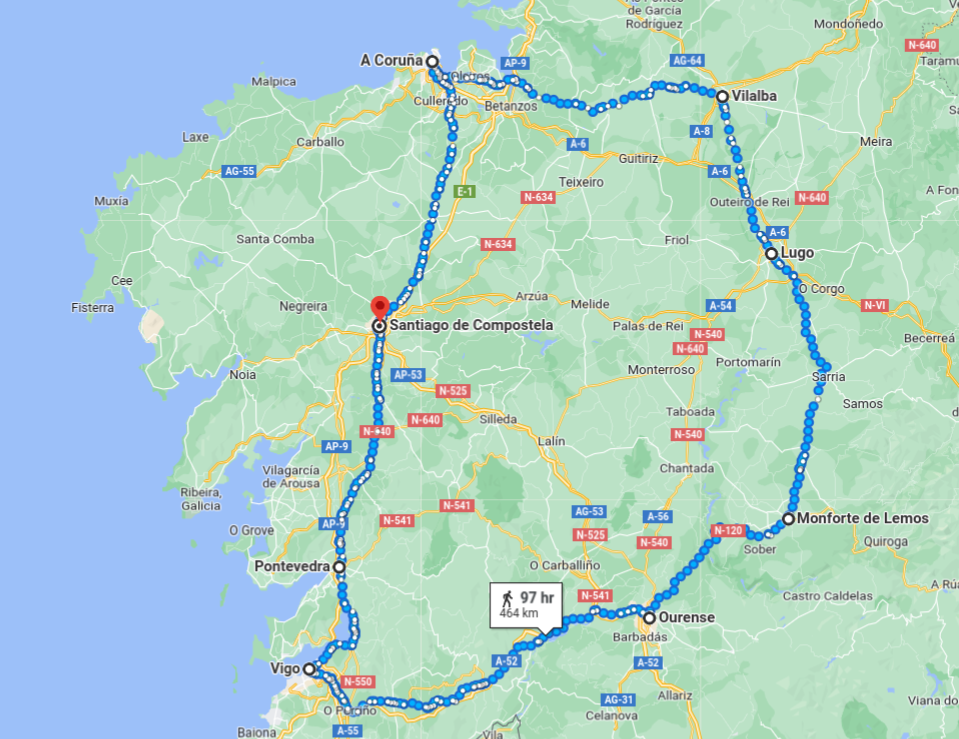

Puedes cargar otro fichero haciendo uso del parámetro `filename` como se muestra a continuación.

In [2]:
g1=Localizaciones(filename='./data/grafo8cidades.txt')
print (g1.distancia(0,1))
g2=Localizaciones(filename='./data/grafos10_10/grafo_1.txt')
print (g2.distancia(0,1))

55.88273580792048
119.30959564041359


### Implementación del problema VC


El VC se reduce al problema de crear el circuito Hamiltoniano de longitud mínima sobre el grafo G. La solución a una instancia del problema del VC puede representarse como una permutación de los índices de las ciudades, donde lo importante es el orden de visita, que determinará el coste del viaje en términos de la distancia recorrida total. 

De este modo, el problema pertenece a la categoría de problemas NP, pues puede haber n permutaciones que se corresponden al espacio de búsqueda posible. Esto hace que resolver instancias de problemas con muchas ciudades (n grande) haga el problema impracticable y éste pueda beneficiarse de búsquedas informadas, que guíen inteligentemente el proceso para reducir el espacio de búsqueda y por tanto el esfuerzo computacional.

Véamos cómo podríamos plantear nuestra implementación del VC. Para hacer la explicación más manejable, supongamos que tomamos las 4 primeras ciudades de nuestro problema de las 8 ciudades gallegas.

 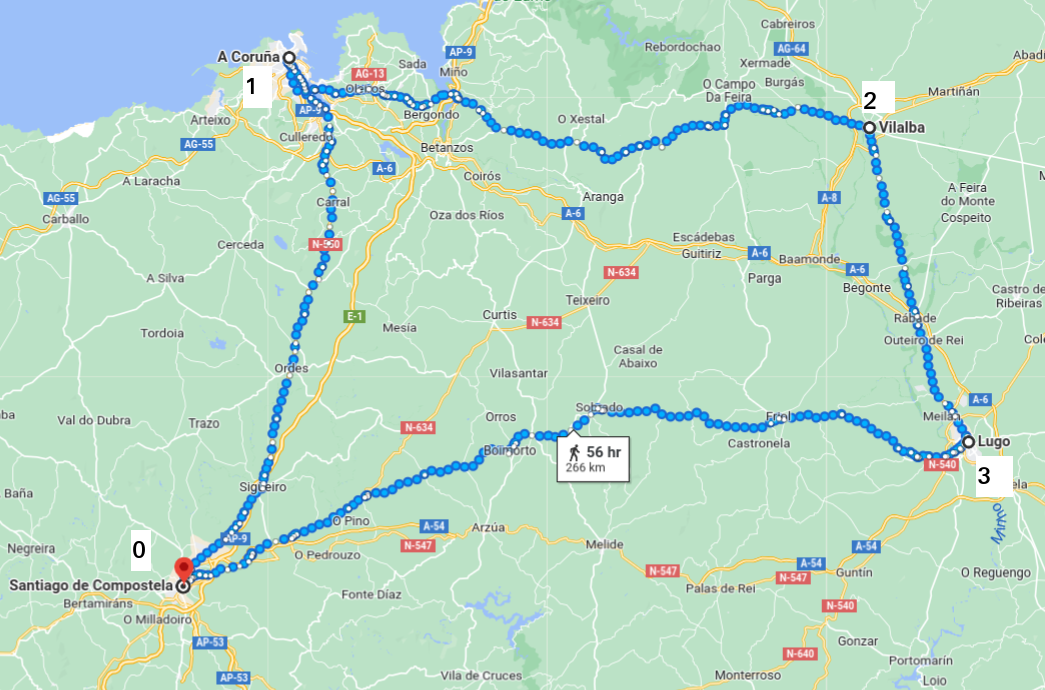


En primer lugar necesitamos determinar una representación adecuada de nuestros estados en el espacio de búsqueda. Aunque se puede hacer de varias formas, una forma razonable sería disponer de una tupla cuyos elementos serían los índices de la ciudades según el orden en que han sido visitadas. 

Por ejemplo, la tupla (0, 1, 3, 2 , 0) representaría un estado que indicaría el siguiente camino: Santiago de Compostela- A Coruña - Lugo - Villalba - Santiago de Compostela. Fíjate que dicho camino es realmente un ciclo, pues la primera y última ciudad son la 0, Santiago de Compostela, y por tanto, podría ser un estado meta. Viendo el mapa de ejemplo, sabemos que pueden haber varios estados meta, y el que sería considerado como solución óptima correspondería a la secuencia (0, 1, 2, 3, 0).

Cabe hacerse ahora algunas preguntas clave. ¿Inicialmente dónde estamos y cuántas ciudades hemos visitado? Efectivamente, de partida estaremos en la ciudad 0, y no habremos visitado ninguna otra ciudad todavía, así que podríamos representar nuestro estado inicial como (0,). 

¿Y si entonces visitamos una segunda ciudad? Pues podríamos ir a A Coruña (1), Villalba (2) o a Lugo (3), lo que daría lugar a los siguientes estados sucesores (0, 1), (0, 2) o (0, 3) respectivamente. 

Imagina que nuestra estrategia selecciona A Coruña. En ese caso, el estado resultante sería (0, 1). A partir de este, nota que los sucesores serían (0, 1, 2) y/o (0, 1, 3), fruto de considerar las otras dos ciudades que no han sido todavía visitadas. Debes fijarte que en estos casos, los estados representan la secuencia de índices mediante una tupla de forma que se va construyendo paso a paso. Y cabe destacar que sabemos que no son estados meta porque no han visitado todas las ciudades y cerrado el ciclo todavía.

A continuación mostramos un árbol de búsqueda representando nuestro espacio de búsqueda. Reflexiona lo que representan los nodos y los arcos. En el caso del VC, ¿dónde representarías el coste del camino? Piénsalo, e indicalo en la pregunta 5 cuando explicas tu implementación.

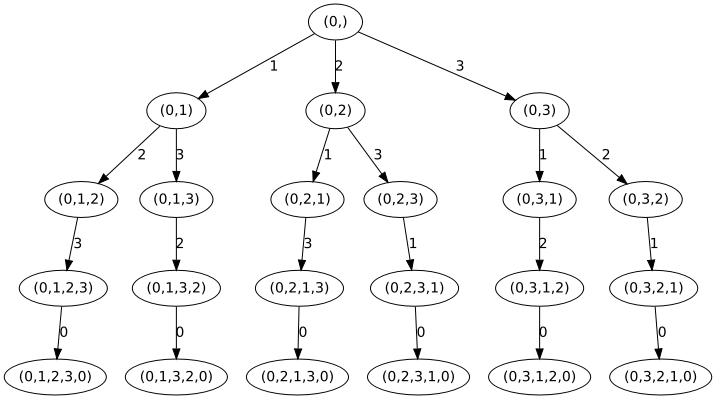

❓ **Pregunta 5**. Implementa el problema del Viajante de Comercio siguiendo las indicaciones y responde a las cuestiones correspondientes.

Tu implementación `ProblemaViajanteComercio` debe extender la clase `Problem` y sobreescribir los métodos `actions, result, is_goal, action_cost` según la representación del estado discutida arriba. 
Por el momento, considera el grafo de las 8 ciudades gallegas y una implementación nula de la heurística, h=0, de forma que debería funcionar como una búsqueda de coste uniforme. 
     Más adelante en la pregunta 6 implementarás las funciones heurísticas.

- 5.1) Explica cómo has implementado los operadores así como el modelo de transición que gobierna la expansión o generación de sucesores de los estados en el espacio de búsqueda. Explica brevemente cuáles han sido los aspectos clave en tu implementación de `actions, result, is_goal, action_cost`. 


In [7]:

class ProblemaViajanteComercio(Problem, Localizaciones):
    """ Problema Viajante de Comercio
    """

    def __init__(self):
        """Define goal state and initialize a problem."""
        self.initial = Localizaciones()  # se recogen los datos del fichero de entrada
        self.ciudades_visitadas = [0]  # lista de ciudades visitadas
        #lista de ciudades no visitadas
        self.ciudades_no_visitadas = [i for i in range(self.initial.nciudades)]
        self.coste_solucion=0
        self.nodos_examinados=0

    def actions(self, state):
        """devuelve la lista de ciudades no visitadas como acciones potenciales."""
        return self.ciudaddes_no_visitadas

    def result(self, state, action):
        """produce el nuevo estado al anadir la accion seleccionada"""
        self.ciudades_visitadas.append(self.ciudades_no_visitadas[action])
        self.ciudades_no_visitadas.remove(self.ciudades_no_visitadas[action])
        return state

    def is_goal(self, state):
        #se cumple si se han visitado todas las ciudades y si se ha vuelto a la ciudad inicial
        return len(self.ciudades_visitadas) == self.initial.nciudades+1 and self.ciudades_visitadas[0] == self.ciudades_visitadas[-1]
        #if(len(self.ciudades_visitadas) == self.initial.nciudades and self.ciudades_visitadas[0] == self.ciudades_visitadas[-1]):
         #   return True
        #return False


    def action_cost(self,s, action, s1):
        """The distance (cost) to go from s to s1."""
        return action.distancia(s, s1)

    def h(self, node):
            return 0

#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()
#inicio la busqueda con h
while (not problem.is_goal(problem.initial)):
    nueva_ciudad = problem.h(problem.ciudades_visitadas[-1])
    if(len(problem.ciudades_no_visitadas)==1):
        problem.coste_solucion+=problem.action_cost(problem.ciudades_visitadas[-1],problem.initial,problem.ciudades_no_visitadas[nueva_ciudad])
        problem.nodos_examinados+=1
        problem.result(localizaciones, nueva_ciudad)
    else:
        problem.coste_solucion+=problem.action_cost(problem.ciudades_visitadas[-1],problem.initial,problem.ciudades_no_visitadas[nueva_ciudad+1])
        problem.nodos_examinados+=1
        problem.result(localizaciones, nueva_ciudad+1)
print("\nLa ruta es: ", problem.ciudades_visitadas)
print("El coste de la solucion es: ", problem.coste_solucion)
print("El numero de nodos visitados es:",problem.nodos_examinados)




La ruta es:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0]
El coste de la solucion es:  1140.0262503041754
El numero de nodos visitados es: 12


### Implementación de heurísticas para VC

La elección de heurísticas que estimen el coste de alcanzar un estado objetivo a partir de un estado dado es crucial para que la estrategia de búsqueda A* sea guiada con mayor eficacia. Recordemos que cuanta más precisa sea la estimación que efectue la función h (i.e., más cercana al coste real), más informada será la búsqueda. Es conveniente que la heurística subestime el coste real para asegurar que la estrategia sigue siendo admisible, y por tanto no descarte estados que puedan conducir a la solución óptima.


❓ **Pregunta 6**. Realiza las implementaciones necesarias para incorporar heurísticas a la implementación A* del VC y responde a las siguientes cuestiones.

- 6.1) Diseña e implementa al menos dos de las siguientes funciones heurísticas que se proponen para una estrategia de búsqueda A* explicando brevemente cómo las has implementado:
    - h1 (n) = vecino más próximo: esta heurística considera como coste estimado la distancia al vecino más próximo que no haya sido visitado todavía, persiguiendo de esta forma que se produzca el mínimo incremento en longitud al añadir la ciudad al camino.
    - h2 (n) = vecino más lejano: esta heurística considera como coste estimado la distancia al vecino más lejano que no haya sido visitado todavía, teniendo en cuenta de esta forma posible coste en que se podría incurrir luego por esos nodos más lejanos pendientes.
    - h3 (n) = distancias medias: esta heurística considera realizar una estimación calculada como la distancia media a los nodos pendientes de visitar.
- 6.2) Utiliza el grafo de las 8 ciudades gallegas como datos de entrada para comprobar la correctitud de tu implementación. ¿Cuál es el la distancia de la solución óptima? Muestra el resultado de la ejecución A* con las heurísticas implementadas.
- 6.3) Para cargar varias instancias del problema como entrada, utiliza algunos ficheros del directorio `./data`, y lleva a cabo la comparación de las heurísticas implementadas. Explica y justifica los resultados obtenidos. 

**Nota:** Ten en cuenta que para extraer conclusiones cinetíficamente válidas puede no ser suficiente utilizar una única instacia del problema como entrada.



3.2La solución óptima es la obtenida por h1 y que da como resultado 

La ruta FINAL es:  [0, 7, 6, 5, 4, 3, 2, 1, 0] y el coste de la solucion es:  381.6699617675482

tambien vale la solucion de h que es identica pero inveresa

La ruta FINAL es:  [0, 1, 2, 3, 4, 5, 6, 7, 0] y el coste de la solucion es:  381.6699617675482


3.3 Las heurísticas funcionan correctamente en todos los casos. Probamos los txt ./data/grafos12_10/grafo_9.txt, ./data/grafos10_10/grafo_10.txt, ./data/grafos12_10/grafo_8.txt, ./data/grafos12_10/grafo_7.txt y el propio ./data/grafo8cidades.txt. 

Los resultados suelen semejarse: la mejor opcion es siempre h1, resultando ser la heurística que siempre encuentra la solución óptima; siempre seguida de h que aunque es una heurística muy simple mejora a las otras 2; seguida siempre de h3 y por último se encuentra h2. 

A parte de estos resultados que mas o menos se mantienen hay excepciones. En el primer caso grafo8cidades.txt la solución óptima la encuentran de igual manera h1 y h, pero esto, es una mera coincidencia ya que en todos los demas casos, al h no basarse en ningún criterio y simplemente recorrer las ciudad en orden por su índice pues no puede asegurarnos buenos resultados. Por el otro lado, h1 al tener un criterio y ademas ser un criterio acertado, obtenemos siemre la mejor solución de todas.

El caso de h3 mejora a h en ./data/grafos12_10/grafo_8.txt pero se debe a una mera coincidencia de ese caso en especial ya que en los demás h siempre se muestra superior. Esto demuestra que a veces un criterio, si este no es el acertado no nos tiene porque dar valores positivos. El problema de h3 es que traza diagonales al solo fijarse en la distancia media mientras que h siempre hace un círculo sin diagonales al recibir en orden las ciudades.

Por último nos encontramos con h2 que obtiene las peores soluciones de todas en cada caso. Si el caso de h3 al buscar la distancia media ya trazaba diagonales innecesarias, en este caso se busca intencionadamente la distancia mas lejana lo que va  a producir muchas mas diagonales evitables obteniendo así el peor resultado.

In [2]:
#Redefinimos Localizaciones para poder comprobar los resultados en otro problema
class Localizaciones ():

    #def __init__ (self, filename='./data/grafos10_10/grafo_10.txt'):
    def __init__ (self, filename='./data/grafos10_10/grafo_3.txt'):
    #def __init__ (self, filename='./data/grafo8cidades.txt'):
        self.filename = filename
        file = open(filename, 'r')
        Lines = file.readlines()

        count = -1
        self.nciudades = 0 
        self.tablaciudades = dict()
        for line in Lines:
            if count == -1:
                self.nciudades = int(line.strip().split()[0])        
            else:
                tokens = line.strip().split()
                self.tablaciudades[count]=tuple((float(tokens[0]),float(tokens[1])))                

            count+=1
    
        self.matriz = []
        for c1 in range(self.nciudades):
            a = [0]*self.nciudades
            self.matriz.append(a)
            for c2 in range(self.nciudades):
                self.matriz[c1][c2] = self.__distancia_semiverseno__(c1, c2)
    
    def __distancia_semiverseno__ (self, c1, c2):
        radioTierra = 6371
        lat1 = math.radians(self.tablaciudades[c1][0]);
        lon1 = math.radians(self.tablaciudades[c1][1]);
        lat2 = math.radians(self.tablaciudades[c2][0]);
        lon2 = math.radians(self.tablaciudades[c2][1]);
        
        sinChi = math.sin((lat2 - lat1) / 2);
        sinLambda = math.sin((lon2 - lon1) / 2);

        raiz = (sinChi * sinChi) + math.cos(lat1) * math.cos(lat2) * (sinLambda * sinLambda);

        return 2 * radioTierra * math.asin(math.sqrt(raiz));
    
    def distancia (self, c1, c2):        
        return self.matriz [c1][c2]

In [12]:
class ProblemaViajanteComercio(Problem):
    """ Problema Viajante de Comercio
    """

    def __init__(self):
        """Define goal state and initialize a problem."""
        self.initial = Localizaciones()  # se recogen los datos del fichero de entrada
        self.ciudades_visitadas = [0]  # lista de ciudades visitadas
        #lista de ciudades no visitadas
        self.ciudades_no_visitadas = [i for i in range(self.initial.nciudades)]
        self.coste_solucion=0
        self.nodos_examinados=0

    def actions(self, state):
        """devuelve la lista de ciudades no visitadas como acciones potenciales."""
        return self.ciudaddes_no_visitadas

    def result(self, state, action):
        """produce el nuevo estado al anadir la accion seleccionada"""
        self.ciudades_visitadas.append(action)
        self.ciudades_no_visitadas.remove(action)
        return state

    def is_goal(self, state):
        #se cumple si se han visitado todas las ciudades y si se ha vuelto a la ciudad inicial
        return len(self.ciudades_visitadas) == self.initial.nciudades+1 and self.ciudades_visitadas[0] == self.ciudades_visitadas[-1]


    def action_cost(self,s, action, s1):
        """The distance (cost) to go from s to s1."""
        return action.distancia(s, s1)

    def h1(self, node,texto):
        """heuristica que devuelve la ciudad con distancia minima entre la ciudad actual y la ciudad no visitada mas cercana"""
        #calculamos la distancia minima entre la ciudad actual y la ciudad no visitada mas cercana
        distancia_min=float('inf')
        if(len(self.ciudades_no_visitadas)>1):
            for ciudad in range(1,len(self.ciudades_no_visitadas)):
                distancia=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                self.nodos_examinados+=1
                if (texto):
                    # imprimimos las ciudades con sus distancias
                    print("CIUDAD ORIGEN: ", node, "CIUDAD DESTINO: ", self.ciudades_no_visitadas[ciudad], "DISTANCIA: ",
                          self.action_cost(node, self.initial, self.ciudades_no_visitadas[ciudad]))
                if (distancia<distancia_min):
                    distancia_min=distancia
                    distancia_coste=distancia
                    city=ciudad
        else:
            city=0
            distancia_coste = self.action_cost(node, self.initial, self.ciudades_no_visitadas[city])
        if (texto):
            print("La ciudad a menor distancia es ", self.ciudades_no_visitadas[city], "\n")
        self.coste_solucion+=distancia_coste
        return self.ciudades_no_visitadas[city]
    #funcion heurística que devuelve las ciudad mas lejana a la ciudad actual
    def h2(self, node,texto):
        """heuristica que devuelve la ciudad con distancia maxima entre la ciudad actual y la ciudad no visitada mas cercana"""
        #calculamos la distancia minima entre la ciudad actual y la ciudad no visitada mas cercana
        distancia_max=0
        if(len(self.ciudades_no_visitadas)>1):
            for ciudad in range(1,len(self.ciudades_no_visitadas)):
                distancia=self.action_cost(node,self.initial,self.ciudades_no_visitadas[ciudad])
                self.nodos_examinados+=1
                if (texto):
                    # imprimimos las ciudades con sus distancias
                    print("CIUDAD ORIGEN: ", node, "CIUDAD DESTINO: ", self.ciudades_no_visitadas[ciudad], "DISTANCIA: ",
                          self.action_cost(node, self.initial, self.ciudades_no_visitadas[ciudad]))
                if (distancia>distancia_max):
                    distancia_max=distancia
                    distancia_coste=distancia
                    city=ciudad

        else:
            city=0
            distancia_coste = self.action_cost(node, self.initial, self.ciudades_no_visitadas[city])
        if (texto):
            print("La ciudad a mayor distancia es ",self.ciudades_no_visitadas[city],"\n")
        self.coste_solucion+=distancia_coste
        #devolvemos el indice de la ciudad mas lejana en la lista de ciudades no visitadas
        return self.ciudades_no_visitadas[city]

    #funcion heuristica que devuelve la ciudad mas proxima a la distancia media de las ciudades no visitadas
    def h3(self, node,texto):
        #calculamos la distancia media de las ciudades no visitadas
        distancia_media=0
        i=0#contador
        for ciudad in range(1,len(self.ciudades_no_visitadas)):
            self.nodos_examinados+=1
            print(self.nodos_examinados)
            if(self.ciudades_no_visitadas[ciudad]!=node):
                distancia_media+=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                i+=1
                if (texto):
                    #imprimimos todas las distancias
                    print(i," CIUDAD ORIGEN: ",node,"CIUDAD DESTINO: ",self.ciudades_no_visitadas[ciudad],"DISTANCIA: ",self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad]))
        if(i!=0):
            distancia_media=distancia_media/i
            if (texto):
                #imprimimos la distancia media
                print("La distancia media es ",distancia_media)
            #buscamos la ciudad mas cercana a la distancia media
            distancia_min=float('inf')
            if(len(self.ciudades_no_visitadas)>1):
                for ciudad in range(1,len(self.ciudades_no_visitadas)):
                    distancia=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                    if (abs(distancia-distancia_media)<distancia_min and distancia!=0):
                        distancia_min=abs(distancia-distancia_media)
                        distancia_coste=distancia
                        city=ciudad
        else:
            city=0
            distancia_coste=self.action_cost(node,self.initial, self.ciudades_no_visitadas[city])
        if(texto):
            print("CIUDAD MAS CERCANA A LA DISTANCIA MEDIA: ",self.ciudades_no_visitadas[city],"\n")
        self.coste_solucion+=distancia_coste
        return self.ciudades_no_visitadas[city]

#funcion para cambiar con facilidad de heurística
'''
@localizacines para poder acceder a los datos
@problem para poder acceder a la clase problem
@texto si marcamos 1: nos muestra texto explicativo de la heurística
       si marcamos 0: no lo hace
@f es la heurística que se desee: h1,h2,h3
'''
def resolver(localizaciones,problem,texto,f):
    while (not problem.is_goal(problem.initial)):
        nueva_ciudad = f(problem.ciudades_visitadas[-1],texto)
        problem.result(localizaciones, nueva_ciudad)
        if(texto):
            print("La ruta es: ", problem.ciudades_visitadas)
    print("\nLa ruta FINAL es: ", problem.ciudades_visitadas) 
    print("El coste de la solucion es: ", problem.coste_solucion)
    print("El numero de nodos visitados es:",problem.nodos_examinados)

In [5]:
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()
#resolver(localizaciones,problem,0,lambda n,t: problem.h1(n,t))
def astar_h1(problem): return astar_search(problem, h=resolver(Localizaciones ,problem,0,lambda n,t: problem.h1(n,t)))
astar_h1(problem)

#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()
def astar_h2(problem): return astar_search(problem, h=resolver(Localizaciones ,problem,1,lambda n,t: problem.h2(n,t)))
astar_h2(problem)
'''
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()
def astar_h3(problem): return astar_search(problem, h=resolver(Localizaciones ,problem,0,lambda n,t: problem.h3(n,t)))
astar_h2(problem)
'''


La ruta FINAL es:  [0, 3, 9, 5, 1, 2, 6, 8, 7, 4, 0]
El coste de la solucion es:  628.6954488851485
El numero de nodos visitados es: 45
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  1 DISTANCIA:  79.85644090565505
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  2 DISTANCIA:  125.45844700338021
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  3 DISTANCIA:  35.69720514881618
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  4 DISTANCIA:  181.563827741593
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  5 DISTANCIA:  65.78486106706886
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  6 DISTANCIA:  147.8225524142972
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  7 DISTANCIA:  152.51008162163305
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  8 DISTANCIA:  115.38856073020455
CIUDAD ORIGEN:  0 CIUDAD DESTINO:  9 DISTANCIA:  57.77561651177916
La ciudad a mayor distancia es  4 

La ruta es:  [0, 4]
CIUDAD ORIGEN:  4 CIUDAD DESTINO:  1 DISTANCIA:  166.42148540565466
CIUDAD ORIGEN:  4 CIUDAD DESTINO:  2 DISTANCIA:  153.106970798297
CIUDAD ORIGEN:  4 CIUDAD DESTINO:  3 DISTANCIA:  195.58499090673607


'\n#creamos las localizaciones\nlocalizaciones = Localizaciones()\n#creamos el problema\nproblem = ProblemaViajanteComercio()\ndef astar_h3(problem): return astar_search(problem, h=resolver(Localizaciones ,problem,0,lambda n,t: problem.h3(n,t)))\nastar_h2(problem)\n'

In [11]:
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()
def astar_h3(problem): return astar_search(problem, h=resolver(Localizaciones ,problem,0,lambda n,t: problem.h3(n,t)))
astar_h2(problem)


La ruta FINAL es:  [0, 8, 4, 11, 5, 6, 7, 2, 10, 3, 1, 9, 0]
El coste de la solucion es:  1314.2679276399556
El numero de nodos visitados es: 66


<<__main__.Localizaciones object at 0x7f7df8b79ac0>>

In [24]:
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()

resolver(localizaciones,problem,0,lambda n,t: problem.h2(n,t))


La ruta FINAL es:  [0, 8, 4, 11, 5, 6, 7, 2, 10, 3, 1, 9, 0]
El coste de la solucion es:  1314.2679276399556 



In [23]:
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()

resolver(localizaciones,problem,0,lambda n,t: problem.h3(n,t))


La ruta FINAL es:  [0, 9, 11, 8, 3, 7, 10, 2, 1, 5, 4, 6, 0]
El coste de la solucion es:  1058.6639151203005 



❓ **Ejercicio opcional:** Diseña e implementa otra función heurística para resolver el problema del VC. Estudia su rendimiento en relación a las otras funciones heurísticas. 

Tal y como sugiere el libro de Russell & Norvig, se puede utilizar una función heurística basada en el árbol de expansión mínima (minimum spanning tree - MST) como subestimación del coste, que se podría obtener mediante los algoritmos de Prim o Kruskal. Puedes considerar diseñar esta o cualquier otra función heurística que se te ocurra, para la cual puedas también justificar su diseño de manera razonada y que en cualquier caso sea más elaborada que las vistas en h1, h2 y h3.

**************************************************************

# Respuestas al cuestionario (8 puntos)

**RECUERDA:** No te olvides de escribir tu nombre y apellidos en la segunda celda del presente documento.

***==================== Pregunta 1 ====================*** *(1 punto)*

**Pregunta 1.1**

La funcion breadth_first_search busca en anchura por lo que tiene una cola de prioridad que va por orden de entrada, en cambio astar_search utiliza una cola de prioridad y le añade según la funcion f(h) = g(n) +h(n) la prioridad de cada nodo, lo que hara que se investigue en diferente orden

**Pregunta 1.2**

La funcion g(n) calcula el coste desde el nodo de inicio.

***==================== Pregunta 2 ====================*** *(1 punto)*

**Pregunta 2.1**

El estado se representa mediante una tupla de enteros que simbolizan la situación del tablero. Los índices
de la tupla se refieren a la posicion en el tablero siguiendo la siguiente estructura: 
                                            012
                                            345
                                            678


**Pregunta 2.2**

El agente inteligente puede utilizar arriba, abajo, izquierda o derecha y las transiciones se realizan gracias a la funcion actions. Esta tiene un vector donde están las posibles transiciones desde cada punto del tablero. Según el indice de la posición sabemos las posibles salidas en este vector.


**Pregunta 2.3**

El coste se actualiza en el nodo, en el atributo path_cost. Los estados se almacenan en cada nodo en el state, para recuperar todos los estados usamos la función recursiva path_states() al tener que ir a los nodos anteriores para recaudar toda la informacion.

**Pregunta 2.4**

La instancia que hemos resuelto es (6,2,7,4,5,1,3,8,0) y el coste ha sido 26

***==================== Pregunta 3 ====================*** *(1 punto)*

**Pregunta 3.1**

Nodes representa los nodos que se han explorado, goal los nodos que se han explorado hasta que encontramos la solución y coste es el coste de la solucion o el coste del camino desde el inicio hasta la solucion.



**Pregunta 3.2**

El gran problema de las búsquedas no informadas es la complejidad temporal que es expositiva por lo que para valores muy grandes se vuelven muy lentas e ineficientes estas situaciones.


**Pregunta 3.3**

Las estrategias que obtienen soluciones óptimas son: búesqueda en anchura, astar_search o A* (si h(n) es admisible) y coste uniforme. 

En otros casos, al depender A* de la heurística sería posible que dejase de obtener las soluciones óptimas al explorar un menor numero de nodos.

Para casos mucho mas complejos, la complejidad temporal y espacial de anchura y coste uniforme podrían jugarnos una mala pasada haciendo que no fuesen capaces de resolver el problema y por lo tanto no obtener la solución óptima.


**Pregunta 3.4**

Con breadth_first_search y uniform_cost_search se obtiene la solucion óptima a costa de explorar una cantidad indigente de nodos  por lo que para problemas de mayor tamaño serían desaconsejables.

En astar_search encontramos el equilibrio entre nodos explorados (ya que es un numero aceptable) y se mantiene la obtención de las soluciones óptimas. Para este problema sería la estrategia más eficiente.

Por otro lado, con greedy_bfs, depth_limited_search y weighted_astar_search ganamos en nodos visitados (ya que son numeros muy puqueños) pero, aun encontrando las soluciones, estas dejan de ser óptimas.


**Pregunta 3.5**

Astar_search utiliza la función heurística de Manhatan que lo que hace es sumar la distancia de todos los puntos a su posicíon final.


***==================== Pregunta 4 ====================*** *(1 punto)*

Comenzamos por destacar una gran diferencia de eficiencia en las busquedas guíadas que en la de anchura, ya que aunque todas llegan a la solución óptima en todos los casos; las estrategías guiadas necesitan visitar un numero ridículo de nodos frente a anchura.Calculamos a continuación la proporcion:

    1. hacemos una media aproximada de los nodos visitados por las busquedas guiadas: (342k+31k+295k)/3=222k
    2. divivimos nodos visitados por la no guiada y la media de las guiadas: 1.246k / 222k = 5,6

Podemos afirmar que las busquedas guiadas son mas de 5 veces y media superiores a las no guiadas.

Ya entrando en la comparación entre las 3 guíadas podemos afirmar, por el numero de nodos visitados, que la más eficiente es h2, seguida de Gasching y esta seguida de h1. Esto se debe a que h2 calcula las distancias por manhatan, es decir, calcula la distancia al sumar todas las distancias de los estados de los nodos al estado final con lo que se logra una gran estimación.

Gasching, en cambio, basa su función heurística en ir nodo uno por uno contando cuantos desplazamientos del elemento vacío hacen falta para llegar a su posición deseada. Con respecto a h2, que la mejora, la diferencia es que Gasching solo se va fijando nodo a nodo mientras que h2 ve el problema de manera más global lo que le permite obtener una mejor solución.

H1 calcula la distancia según hamming, que lo que hace es contar todos los nodos que se encuentran fuera de su posicion final para calcular la distancia. A diferencia de Manhatan y Gasching, hamming no tiene en cuenta de a cuanta distancia se encuentran de la posición final, solo si estan en ella o no; es por esto que se pierde calidad en el guiado y se visitan mas nodos para llegar a la misma posción 

***==================== Pregunta 5 ====================*** *(2.5 puntos)*

**Pregunta 5.1**

En el constructor definimos diferentes variables:
    1. initial que nos permite acceder ala clase Localizaciones donde se lee y se almacenan los valores del fichero de entrada
    2. una lista con las ciudades que han sido visitadas. Se inicia conteniendo la ciudad 0 ya que siempre es el origen
    3. otra lista con las ciudades no visitadas
    4. otra coste_solucion donde iremos almacenando el coste de cada decision que toma la heurística para poder mostrar al final la calidad de la solucion
    
En actions se devuelve simplemente la lista con las ciudades que no han sido visitadas.

Result actualiza las listas de ciudades visitadas y no visitadas.ç

Is_goal comprueba si hemos llegado a la solucion final, esto es si el tamaño de ciudades visitadas es igual a el numero de ciudades +1 (ya que 0 aparece al inicio y al final) y si el primer y el ultimo elemento de la lista de visitadas es igual, vamos, si es 0.

action_cost devuelve lo que costaría realizar el movimiento que se plantea obteniendo el valor de la matriz de la clase localizaciones.

Asi creamos las instancias de localizaciones y problem y entramos en un bucle que solo termina cuando is_goal se cumple. Vamos iterando obteniendo los valores y creamos un if ya que queremos que el valor 0 solo vuelva a aparecer al final.

Para concluir imprimimos la solucion y su coste total


***==================== Pregunta 6 ====================*** *(1.5 puntos)*

**Pregunta 6.1**

h1 busca el vecino mas cercano del nodo en el que nos encontramos. Le pasamos el nodo en el que estamos, hacemos un bucle calculando la distancia mínima desde nuestra posición moviendonos por el índice. En caso de que el tamaño de la lista de nodos no visitados sea igual a 1, sabemos que queda solo el 0 por lo que ya se lo añadimos y evitamos el calculo innecesario.

h2 busca el vecino mas lejano del nodo en el que nos encontramos. Le pasamos el nodo en el que estamos, hacemos un bucle calculando la distancia máxima desde nuestra posición moviendonos por el índice. En caso de que el tamaño de la lista de nodos no visitados sea igual a 1, sabemos que queda solo el 0 por lo que ya se lo añadimos y evitamos el calculo innecesario.

h3 busca el vecino que este a la distancia más proxima a la media de todos. Hacemos un bucle para ir calculando cada distancia para almacenarlas y calcular la media. Le añadimos un contador i para no tener errores al dividir el calculo total para obtener la media. En caso de que i=0 ya sabemos que queda solo el 0 por lo que ya se lo añadimos y evitamos el calculo innecesario. A continuación hacemos otro bucle para buscar el valor más próxima a la media.

Todas las heurísticas tiene un parametro texto, en el que elegimos si queremos que se nos justifique las decisiones que toma marcamos 1 y 0 si solo queremos ver el resultado. Además todas las heurísticas van contando el coste de cada solución para poder compararlas y ver que heurísticas se comportan mejor.

**Pregunta 6.2**

La solución óptima es la obtenida por h1 y que da como resultado 

La ruta FINAL es:  [0, 7, 6, 5, 4, 3, 2, 1, 0] y el coste de la solucion es:  381.6699617675482

tambien vale la solucion de h que es identica pero inveresa

La ruta FINAL es:  [0, 1, 2, 3, 4, 5, 6, 7, 0] y el coste de la solucion es:  381.6699617675482



**Pregunta 6.3**

Las heurísticas funcionan correctamente en todos los casos. Probamos los txt ./data/grafos12_10/grafo_9.txt, ./data/grafos10_10/grafo_10.txt, ./data/grafos12_10/grafo_8.txt, ./data/grafos12_10/grafo_7.txt y el propio ./data/grafo8cidades.txt. 

Los resultados suelen semejarse: la mejor opcion es siempre h1, resultando ser la heurística que siempre encuentra la solución óptima; siempre seguida de h que aunque es una heurística muy simple mejora a las otras 2; seguida siempre de h3 y por último se encuentra h2. 

A parte de estos resultados que mas o menos se mantienen hay excepciones. En el primer caso grafo8cidades.txt la solución óptima la encuentran de igual manera h1 y h, pero esto, es una mera coincidencia ya que en todos los demas casos, al h no basarse en ningún criterio y simplemente recorrer las ciudad en orden por su índice pues no puede asegurarnos buenos resultados. Por el otro lado, h1 al tener un criterio y ademas ser un criterio acertado, obtenemos siemre la mejor solución de todas.

El caso de h3 mejora a h en ./data/grafos12_10/grafo_8.txt pero se debe a una mera coincidencia de ese caso en especial ya que en los demás h siempre se muestra superior. Esto demuestra que a veces un criterio, si este no es el acertado no nos tiene porque dar valores positivos. El problema de h3 es que traza diagonales al solo fijarse en la distancia media mientras que h siempre hace un círculo sin diagonales al recibir en orden las ciudades.

Por último nos encontramos con h2 que obtiene las peores soluciones de todas en cada caso. Si el caso de h3 al buscar la distancia media ya trazaba diagonales innecesarias, en este caso se busca intencionadamente la distancia mas lejana lo que va  a producir muchas mas diagonales evitables obteniendo así el peor resultado.


**Ejercicio Opcional**

Desarollo la heurística 4. Esta devuelve la ciudad de las no visitadas que tiene un vecino a la menor distancia de todos.
Lo que nos obliga a recorrer todas las ciudades que quedan y de cada ciudad buscar la distancia mínima con sus vecinos y ademas luego elegir moverno a la ciudad con el vecino mas cercano lo cual le añade un extra de complicacion frente a h1,h2 y h3 que solo estudiaban sus vecinos inmediatos.

Comprobamos su funcionamiento en los mismos casos que las anteriores y observamos como obtiene buenas soluciones, cercanas a las de h1 pero no las óptimas pero si muy superiores a las de h, h2 o h3. Esto se debe a que sigue un criterioi que hace que visite primero las ciudades que tienen ciudades cerca y demuestra ser acertado pero no perfecto

**************************************************************

# Ejercicio Opcional *(2 puntos)*

❓ **Ejercicio opcional:** Diseña e implementa otra función heurística para resolver el problema del VC. Estudia su rendimiento en relación a las otras funciones heurísticas. 

Tal y como sugiere el libro de Russell & Norvig, se puede utilizar una función heurística basada en el árbol de expansión mínima (minimum spanning tree - MST) como subestimación del coste, que se podría obtener mediante los algoritmos de Prim o Kruskal. Puedes considerar diseñar esta o cualquier otra función heurística que se te ocurra, para la cual puedas también justificar su diseño de manera razonada y que en cualquier caso sea más elaborada que las vistas en h1, h2 y h3.

In [13]:
class ProblemaViajanteComercio(Problem):
    """ Problema Viajante de Comercio
    """

    def __init__(self):
        """Define goal state and initialize a problem."""
        self.initial = Localizaciones()  # se recogen los datos del fichero de entrada
        self.ciudades_visitadas = [0]  # lista de ciudades visitadas
        #lista de ciudades no visitadas
        self.ciudades_no_visitadas = [i for i in range(self.initial.nciudades)]
        self.coste_solucion=0
        self.nodos_examinados=0

    def actions(self, state):
        """devuelve la lista de ciudades no visitadas como acciones potenciales."""
        return self.ciudaddes_no_visitadas

    def result(self, state, action):
        """produce el nuevo estado al anadir la accion seleccionada"""
        self.ciudades_visitadas.append(action)
        self.ciudades_no_visitadas.remove(action)
        return state

    def is_goal(self, state):
        #se cumple si se han visitado todas las ciudades y si se ha vuelto a la ciudad inicial
        return len(self.ciudades_visitadas) == self.initial.nciudades+1 and self.ciudades_visitadas[0] == self.ciudades_visitadas[-1]


    def action_cost(self,s, action, s1):
        """The distance (cost) to go from s to s1."""
        return action.distancia(s, s1)

    def h1(self, node,texto):
        """heuristica que devuelve la ciudad con distancia minima entre la ciudad actual y la ciudad no visitada mas cercana"""
        #calculamos la distancia minima entre la ciudad actual y la ciudad no visitada mas cercana
        distancia_min=float('inf')
        if(len(self.ciudades_no_visitadas)>1):
            for ciudad in range(1,len(self.ciudades_no_visitadas)):
                distancia=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                if (texto):
                    # imprimimos las ciudades con sus distancias
                    print("CIUDAD ORIGEN: ", node, "CIUDAD DESTINO: ", self.ciudades_no_visitadas[ciudad], "DISTANCIA: ",
                          self.action_cost(node, self.initial, self.ciudades_no_visitadas[ciudad]))
                if (distancia<distancia_min):
                    distancia_min=distancia
                    distancia_coste=distancia
                    city=ciudad
        else:
            city=0
            distancia_coste = self.action_cost(node, self.initial, self.ciudades_no_visitadas[city])
        if (texto):
            print("La ciudad a menor distancia es ", self.ciudades_no_visitadas[city], "\n")
        self.coste_solucion+=distancia_coste
        return self.ciudades_no_visitadas[city]
    #funcion heurística que devuelve las ciudad mas lejana a la ciudad actual
    def h2(self, node,texto):
        """heuristica que devuelve la ciudad con distancia maxima entre la ciudad actual y la ciudad no visitada mas cercana"""
        #calculamos la distancia minima entre la ciudad actual y la ciudad no visitada mas cercana
        distancia_max=0
        if(len(self.ciudades_no_visitadas)>1):
            for ciudad in range(1,len(self.ciudades_no_visitadas)):
                distancia=self.action_cost(node,self.initial,self.ciudades_no_visitadas[ciudad])
                if (texto):
                    # imprimimos las ciudades con sus distancias
                    print("CIUDAD ORIGEN: ", node, "CIUDAD DESTINO: ", self.ciudades_no_visitadas[ciudad], "DISTANCIA: ",
                          self.action_cost(node, self.initial, self.ciudades_no_visitadas[ciudad]))
                if (distancia>distancia_max):
                    distancia_max=distancia
                    distancia_coste=distancia
                    city=ciudad

        else:
            city=0
            distancia_coste = self.action_cost(node, self.initial, self.ciudades_no_visitadas[city])
        if (texto):
            print("La ciudad a mayor distancia es ",self.ciudades_no_visitadas[city],"\n")
        self.coste_solucion+=distancia_coste
        #devolvemos el indice de la ciudad mas lejana en la lista de ciudades no visitadas
        return self.ciudades_no_visitadas[city]

    #funcion heuristica que devuelve la ciudad mas proxima a la distancia media de las ciudades no visitadas
    def h3(self, node,texto):
        #calculamos la distancia media de las ciudades no visitadas
        distancia_media=0
        i=0#contador
        for ciudad in range(1,len(self.ciudades_no_visitadas)):
            if(self.ciudades_no_visitadas[ciudad]!=node):
                distancia_media+=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                i+=1
                if (texto):
                    #imprimimos todas las distancias
                    print(i," CIUDAD ORIGEN: ",node,"CIUDAD DESTINO: ",self.ciudades_no_visitadas[ciudad],"DISTANCIA: ",self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad]))
        if(i!=0):
            distancia_media=distancia_media/i
            if (texto):
                #imprimimos la distancia media
                print("La distancia media es ",distancia_media)
            #buscamos la ciudad mas cercana a la distancia media
            distancia_min=float('inf')
            if(len(self.ciudades_no_visitadas)>1):
                for ciudad in range(1,len(self.ciudades_no_visitadas)):
                    distancia=self.action_cost(node,self.initial, self.ciudades_no_visitadas[ciudad])
                    if (abs(distancia-distancia_media)<distancia_min and distancia!=0):
                        distancia_min=abs(distancia-distancia_media)
                        distancia_coste=distancia
                        city=ciudad
        else:
            city=0
            distancia_coste=self.action_cost(node,self.initial, self.ciudades_no_visitadas[city])
        if(texto):
            print("CIUDAD MAS CERCANA A LA DISTANCIA MEDIA: ",self.ciudades_no_visitadas[city],"\n")
        self.coste_solucion+=distancia_coste
        return self.ciudades_no_visitadas[city]
    
    #heursítica que devuelve la ciudad que tiene el vecino mas cercano
    def h4(self, node,texto):
        #heuristica que devuelve la ciudad no visitada que tenga la menor distancia con su vecino mas cercano
        distancias=[len(self.ciudades_no_visitadas)]#lista de las distancias
        ciudades=[len(self.ciudades_no_visitadas)]#lista de las ciudades
        if(len(self.ciudades_no_visitadas)>1):
            for ciudad in range(len(self.ciudades_no_visitadas)):
                self.nodos_examinados+=1
                distancia_min=float('inf')
                for ciudad2 in range(1,len(self.ciudades_no_visitadas)):
                    if(self.ciudades_no_visitadas[ciudad]!=self.ciudades_no_visitadas[ciudad2]):
                        self.nodos_examinados+=1
                        distancia=self.action_cost(self.ciudades_no_visitadas[ciudad],self.initial, self.ciudades_no_visitadas[ciudad2])
                        if(distancia<distancia_min):
                            distancia_min=distancia
                            city=ciudad2
                distancias.append(distancia_min)
                ciudades.append(self.ciudades_no_visitadas[city])
                if(texto):
                    print("CIUDAD ORIGEN: ",node,"CIUDAD VECINO DE ",self.ciudades_no_visitadas[ciudad]," DESTINO: ",self.ciudades_no_visitadas[city],"DISTANCIA: ",distancia_min)
        else:
            city=0
            distancia_min=self.action_cost(self.ciudades_visitadas[-1],self.initial, self.ciudades_no_visitadas[city])
            self.nodos_examinados+=1
            distancias.append(distancia_min)
            ciudades.append(self.ciudades_no_visitadas[city])
            if (texto):
                print("CIUDAD ORIGEN: ", node, "CIUDAD DESTINO: ", self.ciudades_no_visitadas[city], "DISTANCIA: ",
                      distancia_min)
        #buscamos el menor valor de distancias
        distancia_min=float('inf')
        for i in range(1,len(distancias)):
            if(distancias[i]<distancia_min):
                distancia_min=distancias[i]
                city=i
        if(texto):
            print("CIUDAD CON EL VECINO MAS CERCANO: ",ciudades[city],"\n")
        self.coste_solucion+=distancia_min
        return ciudades[city]

#funcion para cambiar con facilidad de heurística
'''
@localizacines para poder acceder a los datos
@problem para poder acceder a la clase problem
@texto si marcamos 1: nos muestra texto explicativo de la heurística
       si marcamos 0: no lo hace
@f es la heurística que se desee: h1,h2,h3,h4
'''
def resolver(localizaciones,problem,texto,f):
    while (not problem.is_goal(problem.initial)):
        nueva_ciudad = f(problem.ciudades_visitadas[-1],texto)
        problem.result(localizaciones, nueva_ciudad)
        if(texto):
            print("La ruta es: ", problem.ciudades_visitadas)
    print("\nLa ruta FINAL es: ", problem.ciudades_visitadas) 
    print("El coste de la solucion es: ", problem.coste_solucion)
    print("El numero de nodos visitados es:",problem.nodos_examinados)

In [15]:
#creamos las localizaciones
localizaciones = Localizaciones()
#creamos el problema
problem = ProblemaViajanteComercio()

resolver(localizaciones,problem,1,lambda n,t: problem.h4(n,t))

CIUDAD ORIGEN:  0 CIUDAD VECINO DE  0  DESTINO:  3 DISTANCIA:  35.69720514881618
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  1  DESTINO:  9 DISTANCIA:  24.41298053165269
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  2  DESTINO:  6 DISTANCIA:  45.88918496340226
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  3  DESTINO:  9 DISTANCIA:  44.598361629315654
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  4  DESTINO:  7 DISTANCIA:  29.89261544222361
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  5  DESTINO:  9 DISTANCIA:  12.755776619551607
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  6  DESTINO:  2 DISTANCIA:  45.88918496340226
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  7  DESTINO:  4 DISTANCIA:  29.89261544222361
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  8  DESTINO:  7 DISTANCIA:  37.22177740919686
CIUDAD ORIGEN:  0 CIUDAD VECINO DE  9  DESTINO:  5 DISTANCIA:  12.755776619551607
CIUDAD CON EL VECINO MAS CERCANO:  9 

La ruta es:  [0, 9]
CIUDAD ORIGEN:  9 CIUDAD VECINO DE  0  DESTINO:  3 DISTANCIA:  35.69720514881618
CIUDAD ORIGEN:  9 CIUDAD VECINO DE  1  DESTINO:

In [2]:
psource(astar_search)

Object `(astar_search)` not found.


**************************************************************